<a href="https://colab.research.google.com/github/mrgrigorii/GUIpygame/blob/master/HOCOMOCO_sites_in_DNA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import array
import copy
import gzip
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive/data

 chromosomesGRCh37  'Jupyter — копия.rar'   sitesV3
 hocomoco	     sites		    sorted_snps_positions_per_type


In [ ]:
os.listdir('drive/My Drive/data/')

['chromosomesGRCh37',
 'sites',
 'sitesV3',
 'hocomoco',
 'sorted_snps_positions_per_type',
 'Jupyter — копия.rar']

In [ ]:
def load_hocomoco_motif(file_name):
    motif_list = []
    with open(file_name, 'r') as f:
        data = f.read().split('>')[1:]
        for motif in data:
            motif = motif.split('\n')
            motif_name = motif[0]
            motif_matrix = list(
                list(map(float, i.split())) + [-10.0] for i in motif[1:] if i
            )
            motif_list.append([motif_name, motif_matrix])

    return motif_list

In [ ]:
def get_lenth_motifs(hcm_matrixes):
    motifs_lenth = [[motif[0], motif[1], len(motif[1])] for motif in hcm_matrixes]
    lenth_motifs = {}
    for motif in motifs_lenth:
        if motif[2] not in lenth_motifs:
            lenth_motifs[motif[2]] = [motif[:2]]
        else:
            lenth_motifs[motif[2]].append(motif[:2])
    return lenth_motifs

In [ ]:
NUCL_STRING = 'ACGT'

def load_fasta_from_gzip(fasta_gzip_name):
    with gzip.open(fasta_gzip_name, 'rb') as f:
        data = f.read().decode("utf-8")
        data = ''.join(data.strip('\n').split('\n')[1:])
        print('Длина ДНК - ', len(data))
        return data


def one_hot_dna(seq):
    ''' Convert ACGT to 0123'''
    seq = seq.replace('A', '0').replace('C', '1').replace('G', '2').replace('T', '3').replace('N', '4').replace('M', '4').replace('R', '4')
    seq = list(map(int, list(seq)))
    seq = torch.tensor(seq, dtype=torch.long)
    seq_onehot = torch.zeros((seq.size()[0], 5), dtype=torch.uint8)
    seq_onehot.scatter_(1, seq.unsqueeze(1), 1)
    seq_onehot = seq_onehot.type(torch.float)
    del seq

    return seq_onehot


def get_reverse_complement(seq):
    seq = seq[::-1]
    seq = seq.replace('A', '0').replace('C', '1').replace('G', '2').replace('T', '3')
    seq = seq.replace('3', 'A').replace('2', 'C').replace('1', 'G').replace('0', 'T')
    return seq


def get_reverse_complement_motif(motif):
    motif = motif.flip(dims=(0,))
    motif = torch.cat((motif.flip(dims=(1,))[:,1:], motif.flip(dims=(1,))[:,:1]), dim=1)
    return motif

In [ ]:
def find_all_motif_scores(motifs_batch, seq, chr_name, buff_len=10000000):

    batch_motifs_len = motifs_batch[0]['motif_tensor'].size()[0]
    for motif in motifs_batch:
        motif['treshold_pass_sites'] =  []
        motif['reverse_treshold_pass_sites'] = []

    iterations = len(seq) // buff_len + 1
    dna_pos = 1
    for i in range(iterations):
        print('Iter', i, iterations)
        useless_tail = - batch_motifs_len + 1  # при подсчете скоров происходит сдвиг влево, потому последние значения не верны
        start_i = i * buff_len if i == 0 else i * buff_len + useless_tail
        end_i = (i + 1) * buff_len if i != iterations - 1 else i * buff_len + len(seq) % buff_len
            
        sub_seq = seq[start_i:end_i]
        if len(sub_seq) < batch_motifs_len:
            continue
        sub_seq = one_hot_dna(sub_seq)
        
        for motif in motifs_batch:
            motif_tensor = motif['motif_tensor']
            reverse_motif_tensor = motif['reverse_motif_tensor']
            treshold = motif['motif_treshold_90']

            mm_motif_seq = torch.mm(motif_tensor, sub_seq.T)
            scores = get_scores(mm_motif_seq, motif_tensor)

            reverse_mm_motif_seq = torch.mm(reverse_motif_tensor, sub_seq.T)
            reverse_scores = get_scores(reverse_mm_motif_seq, reverse_motif_tensor)

            if treshold:
                score_treshold = treshold

                scores = scores[:useless_tail]
                indices = (score_treshold < scores).nonzero()
                for i, value in zip(indices.tolist(), scores[indices].tolist()):
                    motif['treshold_pass_sites'].append('{}\t{}\n'.format(str(i[0] + dna_pos), str(int(round(value[0], 2))*100)))

                reverse_scores = reverse_scores[:useless_tail]
                indices = (score_treshold < reverse_scores).nonzero()
                for i, value in zip(indices.tolist(), reverse_scores[indices].tolist()):
                    motif['reverse_treshold_pass_sites'].append('{}\t{}\n'.format(str(i[0] + dna_pos), str(int(round(value[0], 2))*100)))

        dna_pos += scores.size()[0]
            
    
    for motif in motifs_batch:
        output_gzip_file = motif['output_gzip_file_template'].format(chr_name)
        reverse_output_gzip_file = motif['reverse_output_gzip_file_template'].format(chr_name)

        with gzip.open(output_gzip_file, 'wb') as output_file:
            print('Dumping...', motif['motif_name'])
            output_file.write(''.join(motif['treshold_pass_sites']).encode('utf-8'))
            print('Dumping... - ready!')

        with gzip.open(reverse_output_gzip_file, 'wb') as output_file:
            print('Dumping reverse...', motif['motif_name'])
            output_file.write(''.join(motif['reverse_treshold_pass_sites']).encode('utf-8'))
            print('Dumping  reverse... - ready!')

    return len(motifs_batch)


def get_scores(mm_motif_seq, motif):
    motif_len = motif.size()[0]
    scores = mm_motif_seq[0]
    for i in range(1, motif_len):
        scores += torch.cat((
            mm_motif_seq[i][i:],
            torch.tensor([0 for _ in range(i)], dtype=torch.float)
        ))
    return scores

def join_dicts(dict1, dict2):
    for key, value in dict2.items():
        if key in dict1:
            dict1[key] += value
        else:
            dict1[key] = value
    return dict1

In [ ]:
def best_motif_score(motif):
    best_score = 0
    for i in motif[1]:
        if len(i) > 4:
            i = i[:-1]
        best_score += max(i)
    return best_score


def worst_motif_score(motif):
    worst_score = 0
    for i in motif[1]:
        if len(i) > 4:
            i = i[:-1]
        worst_score += min(i)
    return worst_score

In [ ]:
hcm_matrixes = load_hocomoco_motif('drive/My Drive/data/hocomoco/HOCOMOCOv11_core_pwms_HUMAN_mono.txt')
lenth_motifs = get_lenth_motifs(hcm_matrixes)

In [ ]:
shuffled_motifs_dir = 'drive/My Drive/data/hocomoco/'
def save_motif(motif):
    name = motif[0]
    with open(os.path.join(shuffled_motifs_dir, name + '.txt'), 'w') as out:
        out.write('>%s\n' % motif[0])
        for node in motif[1]:
            out.write('\t'.join(list(map(str, node))) + '\n')

In [ ]:
output_sites_dir = 'drive/My Drive/data/sitesV3/'

def prepare_motifs(lenth_motifs, len_m):
    if len_m not in lenth_motifs:
        print('Error, key {} not exist'.format(len_m))
        return 0
        
    motifs = lenth_motifs[len_m]
    
    motifs_batch = []
    for motif in motifs:
        shuffled_motif = copy.deepcopy(motif)
        random.shuffle(shuffled_motif[1])
        shuffled_motif[0] = 'shuffled_' + shuffled_motif[0]
        save_motif(shuffled_motif)
        
        motif_tensor = torch.tensor(motif[1])
        reverse_motif_tensor = get_reverse_complement_motif(motif_tensor)
        motif_name = motif[0]
        print(motif_name)
        print('best_motif_score', best_motif_score(motif))
        print('worst_motif_score', worst_motif_score(motif))
        print('90% treshold - ', worst_motif_score(motif) + (best_motif_score(motif) - worst_motif_score(motif))*0.9)
        motif_treshold_90 = worst_motif_score(motif) + (best_motif_score(motif) - worst_motif_score(motif))*0.9
        motif_treshold_90 = round(motif_treshold_90, 2)
        
        outupt_dir_path = os.path.join(output_sites_dir, motif_name)
        if not os.path.exists(outupt_dir_path):
            os.makedirs(outupt_dir_path)
        
        output_file_path = os.path.join(outupt_dir_path, '{}_sites.txt.gz')
        reverse_output_file_path = os.path.join(outupt_dir_path, '{}_sites_revers_compl.txt.gz')
        
        motifs_batch.append({
            'motif_name': motif_name,
            'motif_tensor': motif_tensor,
            'reverse_motif_tensor': reverse_motif_tensor,
            'motif_treshold_90': motif_treshold_90,
            'output_gzip_file_template': output_file_path,
            'reverse_output_gzip_file_template': reverse_output_file_path,
        })
    return motifs_batch

In [ ]:
motifs_batch = prepare_motifs(lenth_motifs, len_m=24)

OZF_HUMAN.H11MO.0.C
best_motif_score 30.016436321434384
worst_motif_score -91.05913351738391
90% treshold -  17.908879337552563
Z354A_HUMAN.H11MO.0.C
best_motif_score 22.825122381459668
worst_motif_score -35.63336986122978
90% treshold -  16.97927315719072
ZFP82_HUMAN.H11MO.0.C
best_motif_score 22.895454369305103
worst_motif_score -44.070585192176914
90% treshold -  16.198850413156904
ZN136_HUMAN.H11MO.0.C
best_motif_score 27.64913325806326
worst_motif_score -60.79246750292708
90% treshold -  18.80497318196423
ZN140_HUMAN.H11MO.0.C
best_motif_score 23.989702276851855
worst_motif_score -48.88321321479798
90% treshold -  16.702410727686875
ZN260_HUMAN.H11MO.0.C
best_motif_score 27.817469536637343
worst_motif_score -71.06967558312219
90% treshold -  17.9287550246614
ZN264_HUMAN.H11MO.0.C
best_motif_score 21.608781879390545
worst_motif_score -39.268355679503976
90% treshold -  15.521068123501088
ZN436_HUMAN.H11MO.0.C
best_motif_score 28.655263888353165
worst_motif_score -73.86917641496193


In [ ]:
chromosomes_dir = 'drive/My Drive/data/chromosomesGRCh37/'

def find_sites(motifs_batch):
    for file_name in sorted(os.listdir(chromosomes_dir)):
        print(file_name)
        chr_name = file_name.split('.')[0]

        seq = load_fasta_from_gzip(os.path.join(chromosomes_dir, file_name))
        
        pass_treshold_sites = find_all_motif_scores(
            motifs_batch=motifs_batch,
            seq=seq,
            chr_name=chr_name,
        )

In [ ]:
%time find_sites(motifs_batch)

chr1.fa.gz
Длина ДНК -  249250621
Iter 0 25
Iter 1 25
Iter 2 25
Iter 3 25
Iter 4 25
Iter 5 25
Iter 6 25
Iter 7 25
Iter 8 25
Iter 9 25
Iter 10 25
Iter 11 25
Iter 12 25
Iter 13 25
Iter 14 25
Iter 15 25
Iter 16 25
Iter 17 25
Iter 18 25
Iter 19 25
Iter 20 25
Iter 21 25
Iter 22 25
Iter 23 25
Iter 24 25
Dumping... OZF_HUMAN.H11MO.0.C
Dumping... - ready!
Dumping reverse... OZF_HUMAN.H11MO.0.C
Dumping  reverse... - ready!
Dumping... Z354A_HUMAN.H11MO.0.C
Dumping... - ready!
Dumping reverse... Z354A_HUMAN.H11MO.0.C
Dumping  reverse... - ready!
Dumping... ZFP82_HUMAN.H11MO.0.C
Dumping... - ready!
Dumping reverse... ZFP82_HUMAN.H11MO.0.C
Dumping  reverse... - ready!
Dumping... ZN136_HUMAN.H11MO.0.C
Dumping... - ready!
Dumping reverse... ZN136_HUMAN.H11MO.0.C
Dumping  reverse... - ready!
Dumping... ZN140_HUMAN.H11MO.0.C
Dumping... - ready!
Dumping reverse... ZN140_HUMAN.H11MO.0.C
Dumping  reverse... - ready!
Dumping... ZN260_HUMAN.H11MO.0.C
Dumping... - ready!
Dumping reverse... ZN260_HUMAN.H11MO.

In [ ]:
Wall time: 42min 27s

In [ ]:
Wall time: 3h 39min 11s - 12

In [ ]:
len(histograma.keys())

4215

In [ ]:
items = sorted(histograma.items(), key=lambda x: x[0], reverse=True)
items[:10]

[(904, 2056),
 (872, 1841),
 (867, 2973),
 (862, 640),
 (861, 2466),
 (829, 4342),
 (825, 482),
 (824, 3677),
 (819, 3274),
 (804, 21502)]

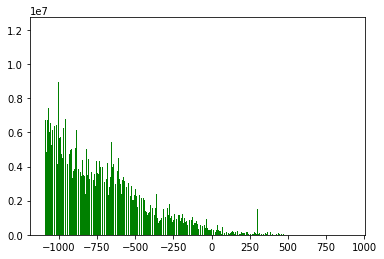

In [ ]:
plt.bar([i[0] for i in items[:-2500]], [i[1] for i in items[:-2500]], color='g')
plt.show()

In [ ]:
# 25 000 генов, пусть TPR равно 5%, тогда возьмем 25 000 * 4 (допустим несколько регуляторов на каждый ген) * (100 / 5) (коррекция на точность)
25000 * 4 * 100 / 5

2000000.0

In [ ]:
n = 700
print(sum([i[1] for i in items[:-2500]][:n]))
print(items[:-2500][n])

91777207
(-72, 571927)


In [ ]:
# Тест

In [ ]:
seq = 'NNNNATATCGCGNNNNATA'
motif = torch.tensor([[1., 0., 0., 0., 0.], [0., 0., 0., 1., 0.], [1., 0., 0., 0., 0.]])
histograma = find_all_motif_scores(motif, seq, buff_len=100,histo=True, treshold=0.001)
histograma

Iter 0 1
Dumping...
Dumping... - ready!
['3\t100\n', '5\t300\n', '7\t200\n', '15\t100\n', '17\t300\n']


({0: 12, 100: 2, 200: 1, 300: 2}, 5)

In [ ]:
# нумерация ДНк идет с единицы, а не не с нуля
n = 17
seq[n - 1:n - 1+3]

'ATA'

In [ ]:
histograma == {0: 12, 100: 2, 200: 1, 300: 2}

True

In [ ]:
import random
for i in range(2, 1000):
    seq = 'AT' * (i - 1)
    motif = torch.tensor([[1., 0., 0., 0., 0.], [0., 0., 0., 1., 0.], [1., 0., 0., 0., 0.]])
    histograma = find_all_motif_scores(motif, seq, buff_len=i)

In [ ]:
histograma

{}

In [ ]:
reverse_complement_seq = get_reverse_complement(seq)
histograma_rev = find_all_motif_scores(motif, reverse_complement_seq)

[]


In [ ]:
print(reverse_complement_seq)
print(histograma_rev)
histograma_rev == {0: 4, 100: 1, 300: 1}

TATNNNNCGCGATATNNNN
{}


False

In [ ]:
# Тест определения позиции (поправка +1)

In [ ]:
seq = load_fasta_from_gzip('../data/chromosomesGRCh37/chr1.fa.gz')
n = 100000
print(seq[n:n+50])

Длина ДНК -  249250621
ACTAAGCACACAGAGAATAATGTCTAGAATCTGAGTGCCATGTTATCAAA


In [ ]:
#seq = 'ATCGATCGCCCCCC'
rev_seq = get_reverse_complement(seq)
n = 100000
print(rev_seq[-(n+50):-n])

TTTGATAACATGGCACTCAGATTCTAGACATTATTCTCTGTGTGCTTAGT


In [ ]:
print(seq[n:n+50])
print(rev_seq[-(n+50):-n][::-1])
print(rev_seq[len(seq)-(n+50):len(seq)-n][::-1])

ACTAAGCACACAGAGAATAATGTCTAGAATCTGAGTGCCATGTTATCAAA
TGATTCGTGTGTCTCTTATTACAGATCTTAGACTCACGGTACAATAGTTT
TGATTCGTGTGTCTCTTATTACAGATCTTAGACTCACGGTACAATAGTTT


In [ ]:
#print(rev_seq[:])
print(rev_seq[::-1])
print(seq)

TAGCTAGCGGGGGG
ATCGATCGCCCCCC


In [ ]:
n = 7 - 1
print(rev_seq[n:n+50])
print(seq[- (n+50): - n])

CGA
TCG


In [ ]:
print(seq[n+45:n+50])

TCAAA


In [ ]:
# тест snp
pos = 238650279
nucl = 'C'
print(seq[pos-1], seq[pos-1] == nucl)
pos = 91544686
nucl = 'TA'
print(seq[pos-1:pos+1], seq[pos-1:pos+1] == nucl)

C True
TA True


In [ ]:
# Тест - правильность поиска мотивов
NUCL_STRING = 'ACGT'

best_motif = ''
best_motif_s = 0
worst_motif_s = 0
print(motif_matrix[0])
for pos in motif_matrix[1]:
    l_np = np.asarray(pos)
    #print(pos, l_np.argmax())
    best_motif += NUCL_STRING[l_np.argmax()]
    best_motif_s += max(l_np)
    worst_motif_s += min(l_np)
print(best_motif)

motif = torch.tensor(motif_matrix[1])
histograma = find_all_motif_scores(motif, best_motif, buff_len=50, histo=True)
print(histograma)
print(best_motif_s, worst_motif_s, worst_motif_s + 0.9 * (best_motif_s - worst_motif_s))

FOXA1_HUMAN.H11MO.0.A
TGTTTACTTTGG
Iter 0 1
Dumping...
Dumping... - ready!
({1200: 1}, 0)
11.998392038250344 -120.0 -1.2014471655746775


In [ ]:
seq_motif = 'TGTTTGCATTCA'
print(seq_motif)
histograma = find_all_motif_scores(motif, seq_motif, buff_len=50, histo=True)
print(histograma)

TGTTTGCATTCA
Iter 0 1
Dumping...
Dumping... - ready!
({728: 1}, 0)


In [ ]:
%time z = torch.mm(x, seq.T)

Wall time: 11 ms


In [ ]:
z.size()

torch.Size([9, 900000])

In [ ]:
z[:, -10:]

tensor([[ 0.0497,  0.0497,  0.0071,  0.0071,  0.0497,  0.3722, -0.7112,  0.0071,
          0.3722,  0.3722],
        [-1.1864, -1.1864,  0.9004,  0.9004, -1.1864, -0.1012, -1.1077,  0.9004,
         -0.1012, -0.1012],
        [-0.5481, -0.5481,  0.5502,  0.5502, -0.5481, -0.5931,  0.1272,  0.5502,
         -0.5931, -0.5931],
        [-2.3461, -2.3461, -1.9796, -1.9796, -2.3461,  1.3087, -2.7362, -1.9796,
          1.3087,  1.3087],
        [-3.4521, -3.4521, -2.4687, -2.4687, -3.4521, -2.6703,  1.3388, -2.4687,
         -2.6703, -2.6703],
        [-2.1350, -2.1350, -3.2061, -3.2061, -2.1350,  1.3323, -2.9650, -3.2061,
          1.3323,  1.3323],
        [-3.4521, -3.4521,  1.3352,  1.3352, -3.4521, -3.0088, -2.1350,  1.3352,
         -3.0088, -3.0088],
        [-3.4521, -3.4521, -3.4521, -3.4521, -3.4521,  1.3622, -3.4521, -3.4521,
          1.3622,  1.3622],
        [ 0.1093,  0.1093, -0.3117, -0.3117,  0.1093, -0.8250,  0.5389, -0.3117,
         -0.8250, -0.8250]])

In [ ]:
z

tensor([[ 0.0497,  0.0071,  0.0071, -0.7112,  0.0497,  0.3722, -0.7112,  0.0071,
          0.0071],
        [-1.1864,  0.9004,  0.9004, -1.1077, -1.1864, -0.1012, -1.1077,  0.9004,
          0.9004],
        [-0.5481,  0.5502,  0.5502,  0.1272, -0.5481, -0.5931,  0.1272,  0.5502,
          0.5502],
        [-2.3461, -1.9796, -1.9796, -2.7362, -2.3461,  1.3087, -2.7362, -1.9796,
         -1.9796],
        [-3.4521, -2.4687, -2.4687,  1.3388, -3.4521, -2.6703,  1.3388, -2.4687,
         -2.4687],
        [-2.1350, -3.2061, -3.2061, -2.9650, -2.1350,  1.3323, -2.9650, -3.2061,
         -3.2061],
        [-3.4521,  1.3352,  1.3352, -2.1350, -3.4521, -3.0088, -2.1350,  1.3352,
          1.3352],
        [-3.4521, -3.4521, -3.4521, -3.4521, -3.4521,  1.3622, -3.4521, -3.4521,
         -3.4521],
        [ 0.1093, -0.3117, -0.3117,  0.5389,  0.1093, -0.8250,  0.5389, -0.3117,
         -0.3117]])

In [ ]:
x = torch.ones(1, 5)
y = torch.ones(5, 1)

In [ ]:
x.tolist()

[[1.0, 1.0, 1.0, 1.0, 1.0]]

In [ ]:
z = torch.mm(x, y.T)
#torch.diagonal(z, offset=0, dim1=-1, dim2=-2)
z0 = z[0]
z1 = torch.cat((z[1][1:], torch.tensor([0 for _ in range(1)])))
z2 = torch.cat((z[2][2:], torch.tensor([0 for _ in range(2)])))
rezult = z0 + z1 + z2
rezult

tensor([[1, 2, 3, 1],
        [4, 5, 6, 4],
        [7, 8, 9, 7]])

In [ ]:
z = torch.mm(x, y)

In [ ]:
z.size()

torch.Size([1, 1])

In [ ]:
z

tensor([[5.]])

In [ ]:
x.size()

torch.Size([1, 5])

In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]])

In [ ]:
torch.mm(x, y.T)

tensor([[1, 2, 3, 1],
        [4, 5, 6, 4],
        [7, 8, 9, 7]])

tensor([1, 5, 9])

In [ ]:
z2 = z[1][1:]

tensor([15, 15,  7,  1])

In [ ]:
z0

tensor([1, 2, 3, 1])

In [ ]:
z1

tensor([5, 6, 4, 0])

In [ ]:
z2

tensor([9, 7, 0, 0])

In [ ]:
batch_size = 5
nb_digits = 5
# Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
y = torch.LongTensor(batch_size,1).random_() % nb_digits
# One hot encoding buffer that you create out of the loop and just keep reusing
y_onehot = torch.FloatTensor(batch_size, nb_digits)

# In your for loop
y_onehot.zero_()
y_onehot.scatter_(1, y, 1)

print(y)
print(y_onehot)

tensor([[0],
        [1],
        [4],
        [4],
        [3]])
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])


In [ ]:
seq = load_fasta_from_gzip('../data/chromosomes/chr1.fna.gz')

Длина ДНК -  248956422


In [ ]:
len(seq)

248956422

In [ ]:
seq = seq.replace('A', '0').replace('C', '1').replace('G', '2').replace('T', '3').replace('N', '4').replace('M', '4').replace('R', '4')

In [ ]:
#set(seq)

In [ ]:
seq_i = list(map(int, list(seq)))

In [ ]:
seq_t = torch.tensor(seq_i, dtype=torch.long)

In [ ]:
seq_t.size()[0]

248956422

In [ ]:
seq = seq.replace('A', '0').replace('C', '1').replace('G', '2').replace('T', '3').replace('N', '4').replace('M', '4').replace('R', '4')
seq_t = torch.tensor(seq_i, dtype=torch.long)
seq_onehot = torch.zeros((seq_t.size()[0], 5), dtype=torch.uint8)
seq_onehot.scatter_(1, seq_t.unsqueeze(1), 1)

In [ ]:
#seq_onehot.zero_()
seq_onehot.scatter_(1, seq_t.unsqueeze(1), 1)

tensor([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]], dtype=torch.uint8)

In [ ]:
seq_onehot.size()

torch.Size([248956422, 5])

In [ ]:
del seq_t